# Predictive Modelling

Predictive Modelling can be proceduralized as follows;

1. <a href='#model_building_and_predicting_section'><b>Model Building And Clustering</b></a>
    - 1.1. <a href='#kmeans_section'><b>K-Means</b></a>
    - 1.2. <a href='#hac_section'><b>Hierarchical Agglomerative Clustering(HAC)</b></a>
    - 1.3. <a href='#dbscan_section'><b>Density-Based Spatial Clustering of Applications with Noise(DBSCAN)</b></a>
    - 1.4. <a href='#gmm_section'><b>Gussian Mixture Models(GMM)</b></a>
2. <a href='#cluster_type_determination_section'><b>Cluster Type Determination</b></a>
3. <a href='#clustering_models_comparison_section'><b>Clustering Models Comparison</b></a>
4. <a href='#predictive_modelling_conclusion_section'><b>Predictive Modelling Conclusion</b></a>

---

## Data Read

In [1]:
# Import necessary libraries for data obtaining
import pandas as pd

In [2]:
# Read the data into a data frame
transformed_data = pd.read_csv('Transformed_Data_Standardized.csv')

In [3]:
transformed_data.head()

,CustomerID,Recency,Frequency,Monetary,Country
0,12346.0,2.302422,-0.746158,-0.724074,United Kingdom
1,12347.0,-0.905954,1.022120,1.727712,Iceland
2,12348.0,-0.183079,-0.461269,0.298304,Finland
3,12349.0,-0.737613,-0.048671,0.275726,Italy
4,12350.0,2.143984,-0.598801,-0.533847,Norway


In [4]:
transformed_data.shape

(4296, 5)

---

<a id='model_building_and_predicting_section'></a>
## 1. Model Building And Clustering

There are 4 methods that are used to cluster customers.<br>
Also, the number of clusters is determined as 3 as default. Because, the simplest assumption should be 3 types of cluster such as desired customer, neutral customer and undesired customer.

<a id='kmeans_section'></a>
### 1.1. K-Means

In the K-Means algorithm, the number of clusters needs to be specified. However, the best number of clusters can be found by using the KElbowVisualizer method.

In [5]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

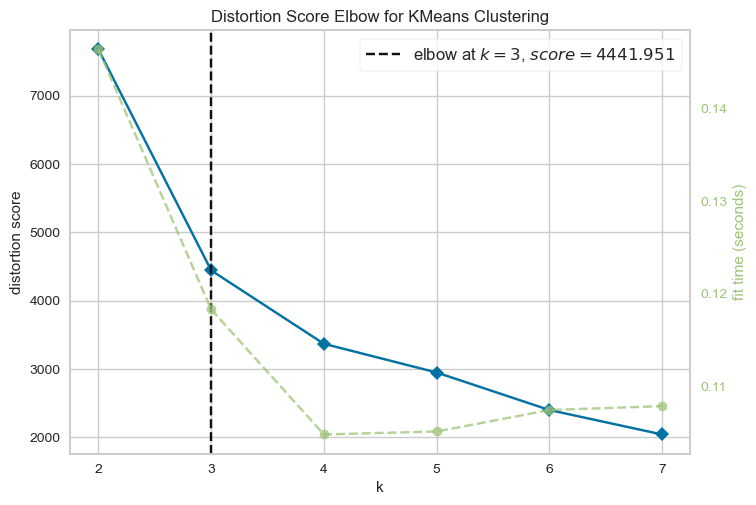

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [6]:
# In order to understand best performed cluster number K-Elbow Method is used
kelbow_visualizer = KElbowVisualizer(KMeans(n_init='auto'), k=(2,8))
kelbow_visualizer.fit(transformed_data.loc[:,['Recency','Frequency','Monetary']])
kelbow_visualizer.show()

As the KElbowVisualizer suggested, k=3 can give the best customer segmentation.\
In order to understand KElbowVisualizer result, Silhouette Graph and its result is used as follows.

---

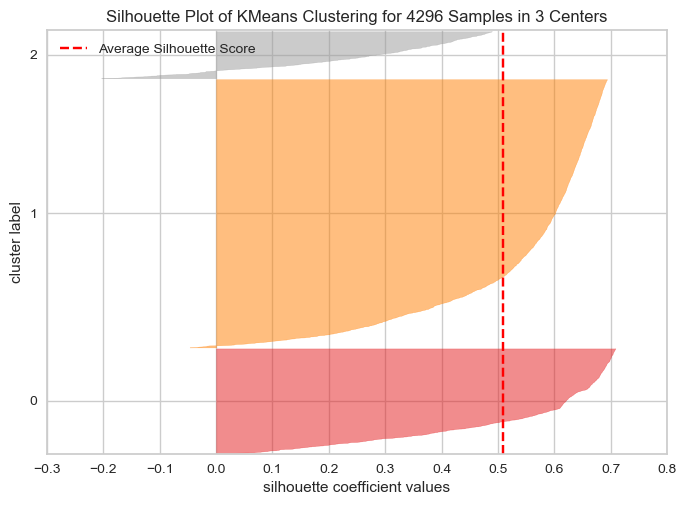

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 4296 Samples in 3 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [7]:
silhouette_visualizer = SilhouetteVisualizer(KMeans(n_clusters=3, n_init='auto'))
silhouette_visualizer.fit(transformed_data.loc[:,['Recency','Frequency','Monetary']])
silhouette_visualizer.show()

According to the KElbowVisualizer and SilhouetteVisualizer method results, the number of the cluster for the dataset should be 3.

---

In [8]:
# model is defined and cluster predictions are obtained
kmeans = KMeans(n_clusters=3, n_init='auto')
k_means_y_hat = kmeans.fit_predict(transformed_data.loc[:,['Recency','Frequency','Monetary']])

In [9]:
# obtained predictions are assigned to a new column in the transform data
transformed_data['KMeans_Cluster'] = k_means_y_hat

<a id='hac_section'></a>
### 1.2. Hierarchical Agglomerative Clustering(HAC)

In [10]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

In [11]:
# model is defined and cluster predictions are obtained
hac = AgglomerativeClustering(n_clusters=3)
hac_y_hat = hac.fit_predict(transformed_data.loc[:,['Recency','Frequency','Monetary']])

In [12]:
# obtained predictions are assigned to a new column in the transform data
transformed_data['Hierarchical_Cluster'] = hac_y_hat

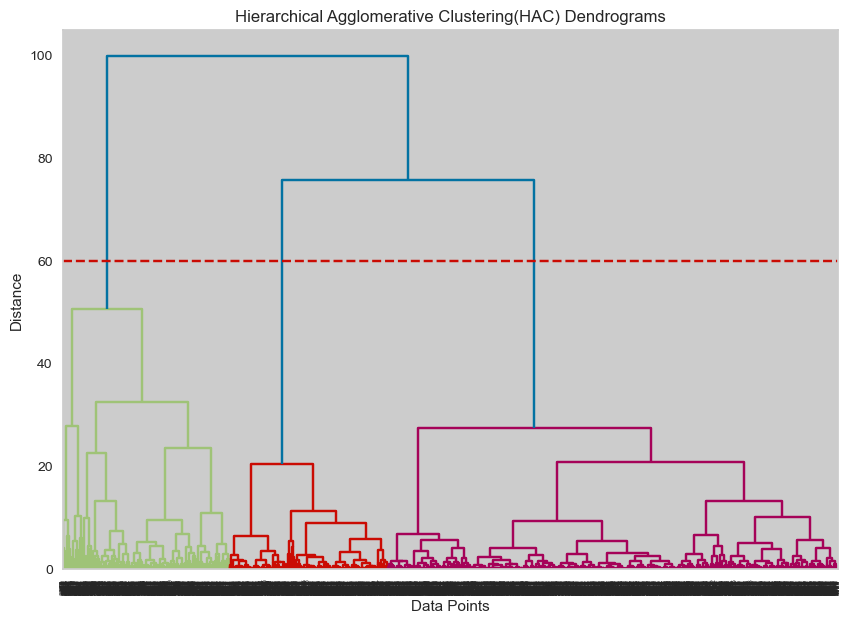

In [13]:
# dendrogram plots
dendrogram_hac = linkage(transformed_data.loc[:,['Recency','Frequency','Monetary']], method='ward')

plt.figure(figsize=(10, 7))  
dendrogram(dendrogram_hac)
plt.axhline(y=60, color='r', linestyle='--')
plt.title("Hierarchical Agglomerative Clustering(HAC) Dendrograms")
plt.xlabel('Data Points')
plt.ylabel('Distance')
plt.show()

<a id='dbscan_section'></a>
### 1.3. Density-Based Spatial Clustering of Applications with Noise(DBSCAN)

In the DBSCAN algorithm, there are two extremely important variables as **Epsilon** and **Minimum Samples**.<br>
- **eps**: Epsilon ---> Radius of a data point
- **min_samples**: Minimum Samples ---> minimum number of data points that can be in the data point circle with epsilon radius

**Epsilon** can be determined by using maximum curvature of the **K-Distance Graph** and K-Distance graph is formed by using distance values that come from NearestNeighbors algorithm.<br>
**Minimum Samples** are generally determined as **2**x**Dimensions**. However, it can be determined as the domain knowledge suggested.<br>
<br>
One of the advantages of the DBSCAN model is the noise determination. After clustering, the model returns one extra cluster as **-1** that represents **noise**.

In [14]:
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
import numpy as np

In [15]:
# distance determination between each two data points
neighbors = NearestNeighbors(n_neighbors=2)
neighbors_fitted = neighbors.fit(transformed_data.loc[:,['Recency','Frequency','Monetary']])
distances, indices = neighbors_fitted.kneighbors(transformed_data.loc[:,['Recency','Frequency','Monetary']])

Text(0.5, 1.0, 'K-Distance Graph For Online Retail Dataset')

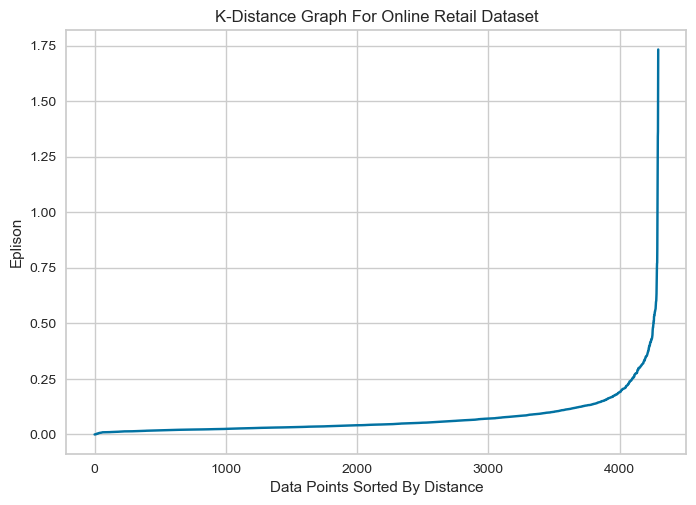

In [16]:
# K-Distance Graph
distances = np.sort(distances, axis=0)[:,1]
plt.plot(distances)
plt.xlabel('Data Points Sorted By Distance')
plt.ylabel('Eplison')
plt.title('K-Distance Graph For Online Retail Dataset')

According to the K-Distance Graph, maximum curvature should be around 0.25. Therefore, Epsilon is assumed as **eps=0.258**.\
Minimum sample is determined as **min_samples = 2*3(Features) = 6**

In [17]:
# model is defined and cluster predictions are obtained
dbscan = DBSCAN(eps=0.258, min_samples=6)
dbscan.fit(transformed_data.loc[:,['Recency','Frequency','Monetary']])

DBSCAN(eps=0.258, min_samples=6)

In [18]:
# obtained predictions are assigned to a new column in the transform data
transformed_data['DBSCAN_Cluster'] = dbscan.labels_

In [19]:
# all clusters and their counts with NOISE
transformed_data['DBSCAN_Cluster'].value_counts()

 0    3881
-1     398
 1      11
 2       6
Name: DBSCAN_Cluster, dtype: int64

<a id='gmm_section'></a>
### 1.4. Gussian Mixture Models(GMM)

In [20]:
from sklearn.mixture import GaussianMixture

In [21]:
gmm = GaussianMixture(n_components=3)
gmm_y_hat = gmm.fit_predict(transformed_data.loc[:,['Recency','Frequency','Monetary']])

In [22]:
# obtained predictions are assigned to a new column in the transform data
transformed_data['GMM_Cluster'] = gmm_y_hat

---

<a id='cluster_type_determination_section'></a>
## 2. Cluster Type Determination

**!!!** Low Recency, High Frequency and Monetary customers are most desirable customers

In [23]:
import seaborn as sns

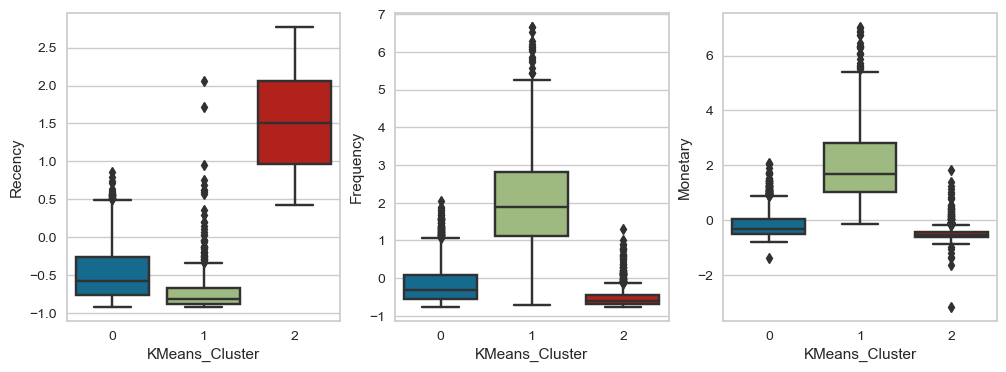

In [24]:
# K-Means Clusters
x_axis = transformed_data['KMeans_Cluster']
plt.figure(figsize=(12,4))
for i in range(1,4):
    plt.subplot(1,3,i)
    sns.boxplot(x=x_axis, y=transformed_data.iloc[:,i])

In the **K-Means** Clustering algorithm,
- Cluster **0**: **Moderately-Desired** Customers
- Cluster **1**: **Under-Desired** Customers
- Cluster **2**: **Over-Desired** Customers

---

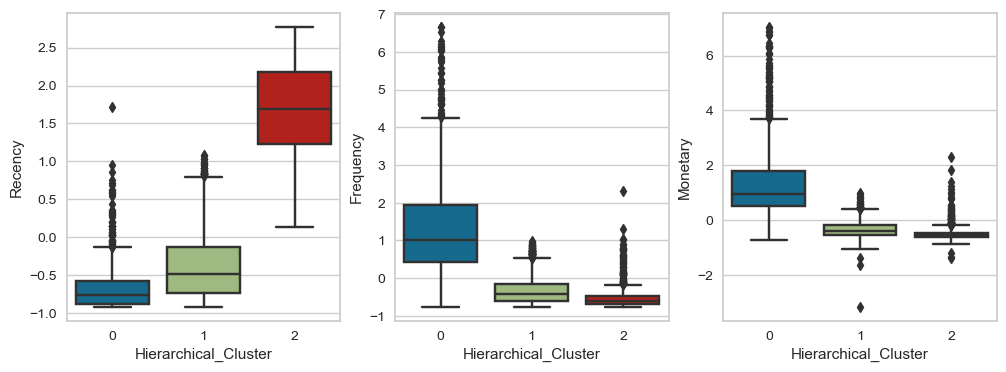

In [25]:
# Hierarchical(HAC) Clusters
x_axis = transformed_data['Hierarchical_Cluster']
plt.figure(figsize=(12,4))
for i in range(1,4):
    plt.subplot(1,3,i)
    sns.boxplot(x=x_axis, y=transformed_data.iloc[:,i])

In the **Hierarchical(HAC)** Clustering algorithm,
- Cluster **0**: **Over-Desired** Customers 
- Cluster **1**: **Moderately-Desired** Customers
- Cluster **2**: **Under-Desired** Customers

---

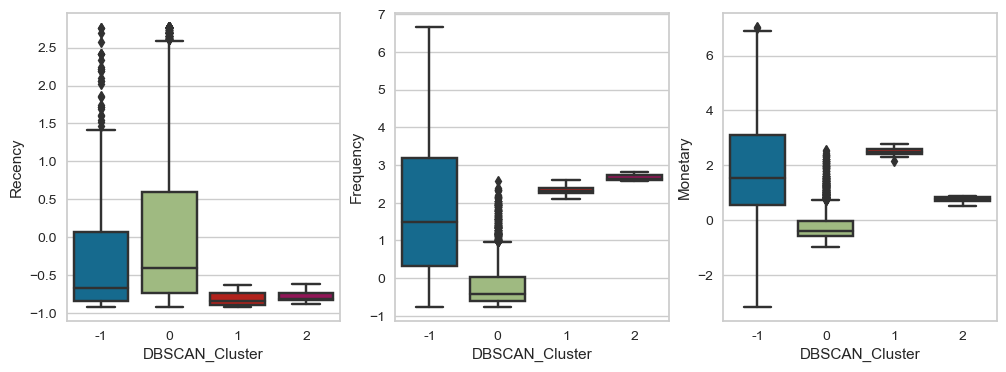

In [26]:
# DBSCAN Clusters
x_axis = transformed_data['DBSCAN_Cluster']
plt.figure(figsize=(12,4))
for i in range(1,4):
    plt.subplot(1,3,i)
    sns.boxplot(x=x_axis, y=transformed_data.iloc[:,i])

In the **DBSCAN** Clustering algorithm,
- Cluster -**1**: **Clustered as Noise** Customers 
- Cluster **0**: **Over-Desired** Customers 
- Cluster **1**: **Moderately-Desired** Customers
- Cluster **2**: **Under-Desired** Customers

---

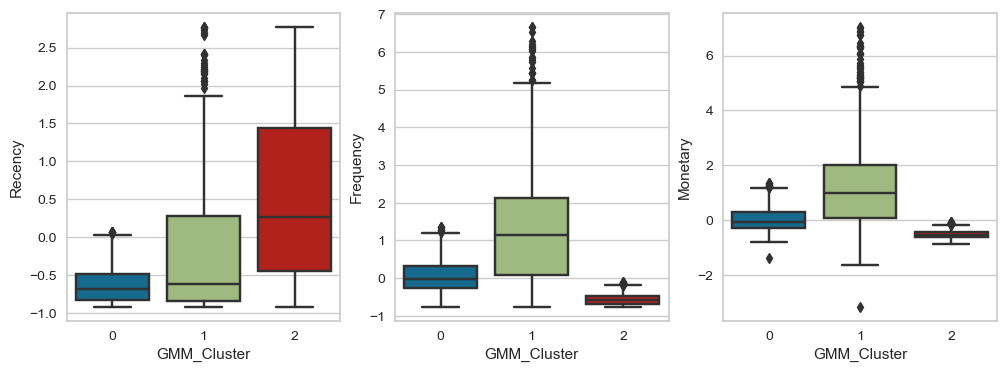

In [27]:
# Gaussian Mixture Clusters
x_axis = transformed_data['GMM_Cluster']
plt.figure(figsize=(12,4))
for i in range(1,4):
    plt.subplot(1,3,i)
    sns.boxplot(x=x_axis, y=transformed_data.iloc[:,i])

In the **Gaussian Mixture** Clustering algorithm,
- Cluster **0**: **Over-Desired** Customers
- Cluster **1**: **Under-Desired** Customers
- Cluster **2**: **Moderately-Desired** Customers

---

<a id='clustering_models_comparison_section'></a>
## 3. Clustering Models Comparison

0, 1, and 2 cluster lables refers different things in the models.<br>
Therefore, **Over-Desired** Customer Cluster is represented with **Blue**, <br>
**Moderately-Desired** Customer Cluster is represented with **Orange** and <br>
**Under-Desired** Customer Cluster is represented with **Red**. <br>
Also, **Noise** is represented with **Black** in the graphs.

In [28]:
under = '#C0392B' # red
moderate = '#F39C12' # orange
over = '#1F618D' # blue
noise = '#000000' # black

[Text(0.5, 1.0, 'Recency-Frequency Graph With Gaussian Micture Model Clusters')]

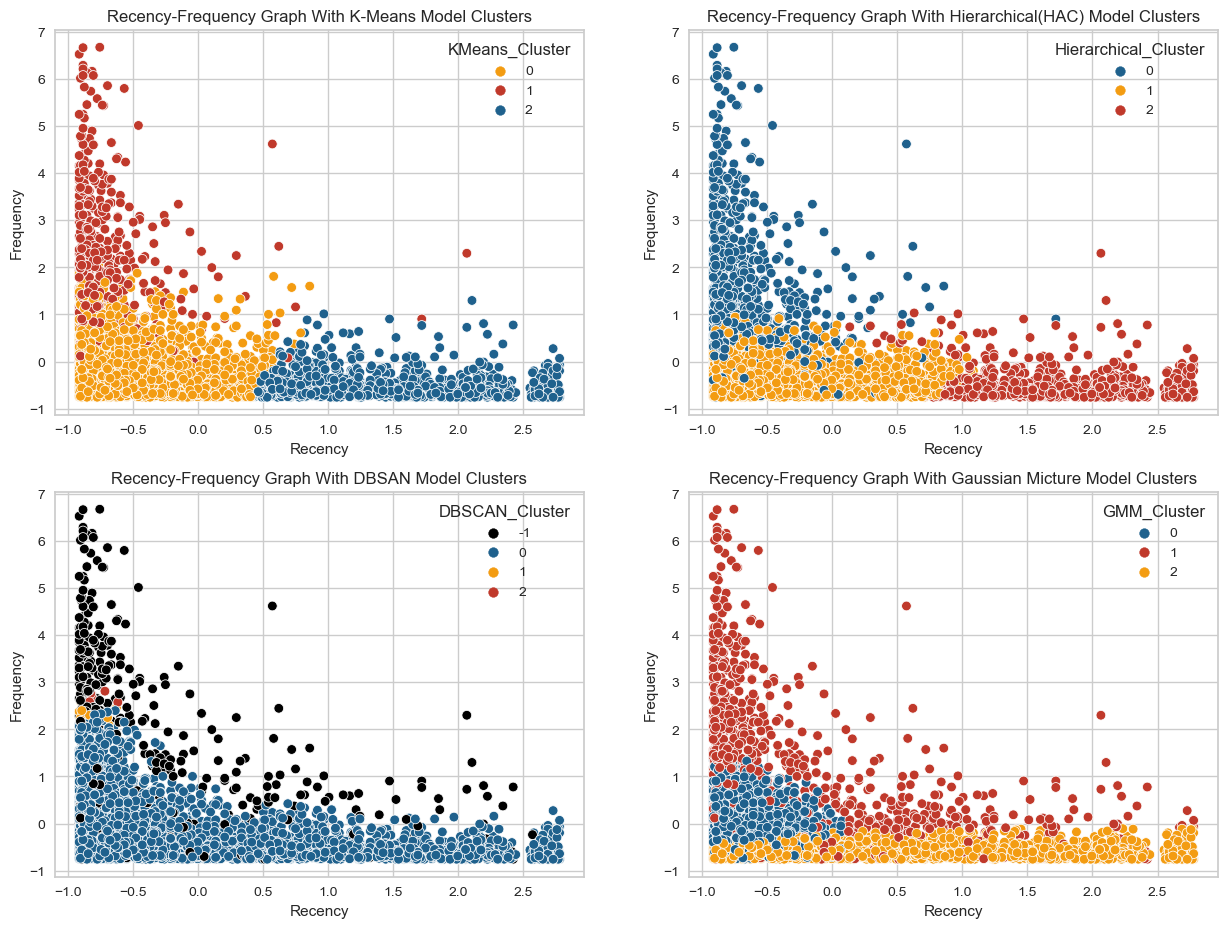

In [29]:
# Recency - Frequency Attributes
plt.figure(figsize=(15,11))

plt.subplot(2,2, 1)
fig = sns.scatterplot(transformed_data, x='Recency' ,y='Frequency', hue='KMeans_Cluster', palette={0:moderate, 1:under, 2:over})
fig.set(title='Recency-Frequency Graph With K-Means Model Clusters')

plt.subplot(2,2, 2)
fig = sns.scatterplot(transformed_data, x='Recency' ,y='Frequency', hue='Hierarchical_Cluster', palette={0:over, 1:moderate, 2:under})
fig.set(title='Recency-Frequency Graph With Hierarchical(HAC) Model Clusters')

plt.subplot(2,2, 3)
fig = sns.scatterplot(transformed_data, x='Recency' ,y='Frequency', hue='DBSCAN_Cluster', palette={-1:noise, 0:over, 1:moderate, 2:under})
fig.set(title='Recency-Frequency Graph With DBSAN Model Clusters')

plt.subplot(2,2, 4)
fig = sns.scatterplot(transformed_data, x='Recency' ,y='Frequency', hue='GMM_Cluster', palette={0:over, 1:under, 2:moderate})
fig.set(title='Recency-Frequency Graph With Gaussian Micture Model Clusters')

[Text(0.5, 1.0, 'Recency-Monetary Graph With Gaussian Micture Model Clusters')]

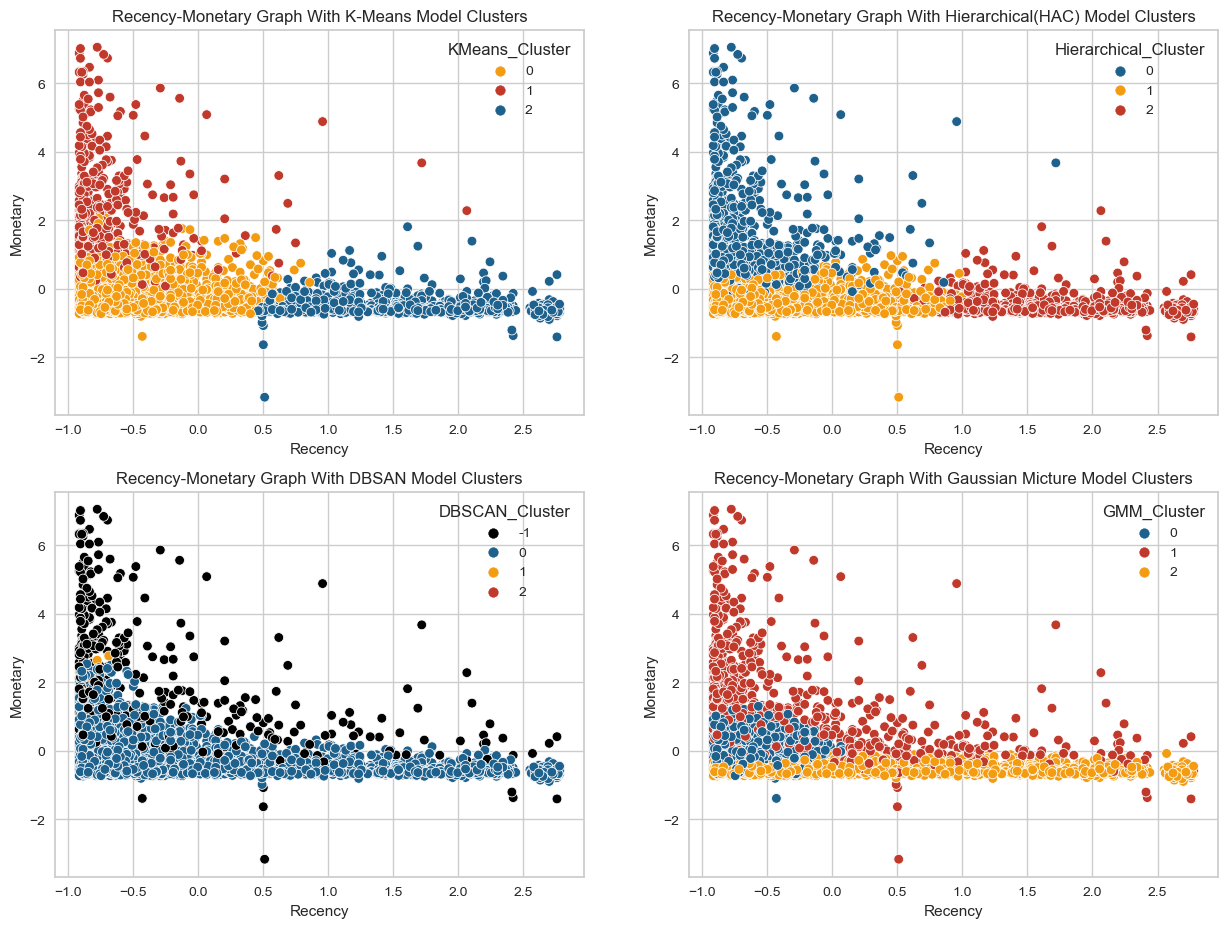

In [30]:
# Recency - Monetary Attributes
plt.figure(figsize=(15,11))

plt.subplot(2,2, 1)
fig = sns.scatterplot(transformed_data, x='Recency' ,y='Monetary', hue='KMeans_Cluster', palette={0:moderate, 1:under, 2:over})
fig.set(title='Recency-Monetary Graph With K-Means Model Clusters')

plt.subplot(2,2, 2)
fig = sns.scatterplot(transformed_data, x='Recency' ,y='Monetary', hue='Hierarchical_Cluster', palette={0:over, 1:moderate, 2:under})
fig.set(title='Recency-Monetary Graph With Hierarchical(HAC) Model Clusters')

plt.subplot(2,2, 3)
fig = sns.scatterplot(transformed_data, x='Recency' ,y='Monetary', hue='DBSCAN_Cluster', palette={-1:noise, 0:over, 1:moderate, 2:under})
fig.set(title='Recency-Monetary Graph With DBSAN Model Clusters')

plt.subplot(2,2, 4)
fig = sns.scatterplot(transformed_data, x='Recency' ,y='Monetary', hue='GMM_Cluster', palette={0:over, 1:under, 2:moderate})
fig.set(title='Recency-Monetary Graph With Gaussian Micture Model Clusters')

[Text(0.5, 1.0, 'Frequency-Monetary Graph With Gaussian Micture Model Clusters')]

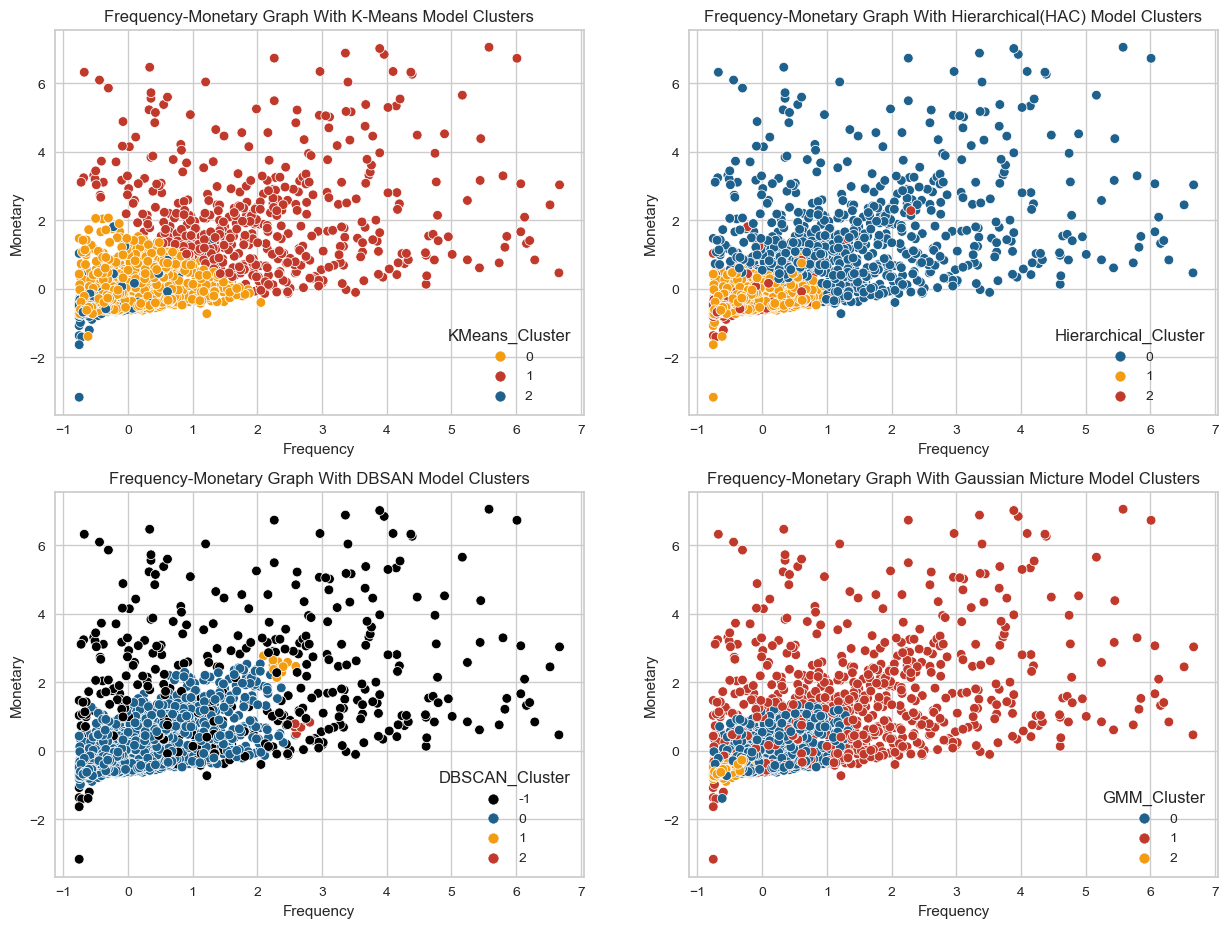

In [31]:
# Frequency - Monetary Attributes
plt.figure(figsize=(15,11))

plt.subplot(2,2, 1)
fig = sns.scatterplot(transformed_data, x='Frequency' ,y='Monetary', hue='KMeans_Cluster', palette={0:moderate, 1:under, 2:over})
fig.set(title='Frequency-Monetary Graph With K-Means Model Clusters')

plt.subplot(2,2, 2)
fig = sns.scatterplot(transformed_data, x='Frequency' ,y='Monetary', hue='Hierarchical_Cluster', palette={0:over, 1:moderate, 2:under})
fig.set(title='Frequency-Monetary Graph With Hierarchical(HAC) Model Clusters')

plt.subplot(2,2, 3)
fig = sns.scatterplot(transformed_data, x='Frequency' ,y='Monetary', hue='DBSCAN_Cluster', palette={-1:noise, 0:over, 1:moderate, 2:under})
fig.set(title='Frequency-Monetary Graph With DBSAN Model Clusters')

plt.subplot(2,2, 4)
fig = sns.scatterplot(transformed_data, x='Frequency' ,y='Monetary', hue='GMM_Cluster', palette={0:over, 1:under, 2:moderate})
fig.set(title='Frequency-Monetary Graph With Gaussian Micture Model Clusters')

---

<a id='predictive_modelling_conclusion_section'></a>
## 4. Predictive Modelling Conclusion

In [ ]:
# General summary of the scaled dataset is presented here. Also, necessary advice is proposed etc. ...

In this project, 4 most popular Unsupervised Machine Learning algorithms for clustering are applied to the standardized transform dataset. Results of these models are as follows; there are too many outliers in the Hierarchical Model results, there are too many noises in the DBSCAN model. Therefore, K-Means and Gaussian Mixture models segmented the data better than other two models.

---